## Connect to Google Drive to download JSON file with preprocessed data

In [1]:
import librosa
import librosa.display

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data from preprocessed JSON

In [2]:
import json

import librosa
import librosa.display

from google.colab import drive
drive.mount('/content/drive')

def load_data(json_path):
  with open(json_path, "r") as fp:
        data = json.load(fp)

  X = (data['mfcc'])
  y = (data['labels'])
  return X, y

json_path = '/content/drive/MyDrive/DL/Project/Data/preprocess/mel_specs.json'
X, y = load_data(json_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Refactor data into numpy array of spectrograms

In [3]:
import numpy as np

x_data, y_data = [], []
for i in range(len(X)):
  x_d = X[i]
  for j in range(len(x_d)):
    x_data.append(np.array(x_d[j]).T)
    y_data.append(y[i])
X = np.array(x_data)
y = np.array(y_data)

## Split data into train and test sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape

(6990, 13, 130)

## Divide data into pairs

In [5]:
def create_pairs(plots, labels):
  pair_plots, pair_labels = [], []
  num_labels = len(np.unique(labels))
  
  indices = [np.where(labels == i)[0] for i in range(num_labels)]
  
  for idx1 in range(plots.shape[0]):
    plot1 = plots[idx1]
    label1 = labels[idx1]

    idx2 = np.random.choice(indices[label1])
    plot2 = plots[idx2]

    pair_plots.append([plot1, plot2])
    pair_labels.append([1])

    idx3 = np.where(labels != label1)[0]
    plot3 = plots[np.random.choice(idx3)]

    pair_plots.append([plot1, plot3])
    pair_labels.append([0])
  return (np.array(pair_plots), np.array(pair_labels))

tr_pairs, tr_y = create_pairs(X_train, y_train)
ts_pairs, ts_y = create_pairs(X_test, y_test)

## Initialize network

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

def initialize_base_network():
    input = Input(shape=(13,130,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [7]:
base_network = initialize_base_network()

shape = (13,130,)
# create the left input and point to the base network
input_a = Input(shape=shape, name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=shape, name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

### Single netowrk representation

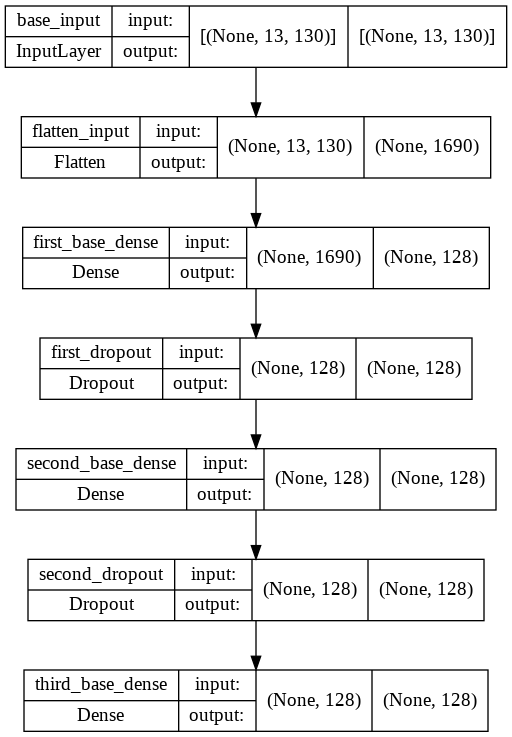

In [8]:
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

### Siamese netowrk representation

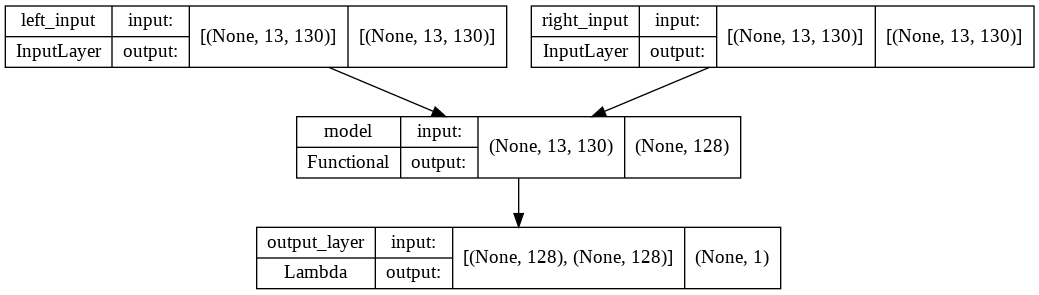

In [9]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [10]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

## Train model

In [11]:
tr_y = tf.cast(tr_y, tf.float32)
ts_y = tf.cast(ts_y, tf.float32)
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y[:], epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y[:]))

Epoch 1/20
110/110 [==============================] - 3s 19ms/step - loss: 832.7750 - val_loss: 4.4410
Epoch 2/20
110/110 [==============================] - 2s 15ms/step - loss: 6.8700 - val_loss: 0.5094
Epoch 3/20
110/110 [==============================] - 2s 15ms/step - loss: 2.3556 - val_loss: 0.4999
Epoch 4/20
110/110 [==============================] - 2s 15ms/step - loss: 0.9286 - val_loss: 0.5053
Epoch 5/20
110/110 [==============================] - 2s 15ms/step - loss: 0.6185 - val_loss: 0.5243
Epoch 6/20
110/110 [==============================] - 2s 15ms/step - loss: 0.5154 - val_loss: 0.4997
Epoch 7/20
110/110 [==============================] - 2s 15ms/step - loss: 0.6715 - val_loss: 0.4996
Epoch 8/20
110/110 [==============================] - 2s 15ms/step - loss: 0.7201 - val_loss: 0.4995
Epoch 9/20
110/110 [==============================] - 2s 15ms/step - loss: 0.9288 - val_loss: 0.4923
Epoch 10/20
110/110 [==============================] - 2s 15ms/step - loss: 0.9410 - val_

In [12]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

## Compute accuracy

In [13]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

188/188 [==============================] - 1s 3ms/step - loss: 0.3894
Loss = 0.3893842101097107, Train Accuracy = 0.5 Test Accuracy = 0.5


## Plot results

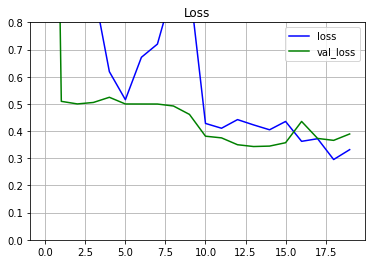

In [14]:
import matplotlib.pyplot as plt

def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.grid()
    plt.legend()

plot_metrics(metric_name='loss', title="Loss", ylim=0.8)